# 1. Problem Framing

## Solving the problems of vaccination in a globalised society.

In the course of this project, we represent a group of concerned lobbyists, who have created a data science model for the US Government. In the current climate of Coronavirus panic, along with the rising tide of anti-science denialism (a la the documentary 'Vaxxed'), more effort than ever is needed to ensure protection against disease. In our study, we began by identifying the states with the lowest flu vaccine uptake, before then identifying the factors most likely to impact it nationwide. The conclusion is focussed on those areas most actionable, and includes strategies for increasing immunisation of the popluation.

# 2. Importing Python Libraries and .CSV File

In [1]:
import pandas as pd
pd.set_option('display.max_rows',10000)
pd.set_option('display.max_columns',999)
import numpy as np
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet,ElasticNetCV
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import sklearn.metrics

Creating a pandas dataframe from the .csv file.

In [2]:
df = pd.read_csv('analytic_data2019.csv')

Checking to see that the dataframe has been created correctly. This also allows us to take a first look at what variables are contained in the dataset.

In [3]:
df.head()

State FIPS Code County FIPS Code 5-digit FIPS Code State Abbreviation  \
0       statecode       countycode          fipscode              state   
1              00              000             00000                 US   
2              01              000             01000                 AL   
3              01              001             01001                 AL   
4              01              003             01003                 AL   

             Name Release Year County Ranked (Yes=1/No=0)  \
0          county         year              county_ranked   
1   United States         2019                        NaN   
2         Alabama         2019                        NaN   
3  Autauga County         2019                          1   
4  Baldwin County         2019                          1   

  Premature death raw value Premature death numerator  \
0             v001_rawvalue            v001_numerator   
1               6900.630354                   3745538   
2              9917.2328984                     80440   
3              8824.0571232                       815   
4              7224.6321603                      2827   

  Premature death denominator Premature death CI low Premature death CI high  \
0            v001_denominator             v001_cilow             v001_cihigh   
1                   908266078           6890.3492059             6910.911502   
2                    13636816           9815.1909454            10019.274852   
3                      156132           7935.3258295            9712.7884169   
4                      576496           6794.1283802            7655.1359403   

  Premature death (Black) Premature death (Hispanic) Premature death (White)  \
0         v001_race_black         v001_race_hispanic         v001_race_white   
1                     NaN                        NaN                     NaN   
2                     NaN                        NaN                     NaN   
3            10471.252986                        NaN            8706.6588323   
4            10042.472874               3086.6056945            7277.7807271   

  Poor or fair health raw value Poor or fair health numerator  \
0                 v002_rawvalue                v002_numerator   
1                           NaN                           NaN   
2                  0.2140240566                           NaN   
3                  0.1841112436                           NaN   
4                  0.1806045782                           NaN   

  Poor or fair health denominator Poor or fair health CI low  \
0                v002_denominator                 v002_cilow   
1                             NaN                        NaN   
2                             NaN               0.2009537484   
3                             NaN               0.1784404913   
4                             NaN               0.1752150037   

  Poor or fair health CI high Poor physical health days raw value  \
0                 v002_cihigh                       v036_rawvalue   
1                         NaN                                 NaN   
2                0.2277022217                        4.4004575204   
3                0.1903231618                        4.2005779826   
4                0.1858667304                        4.0987477691   

  Poor physical health days numerator Poor physical health days denominator  \
0                      v036_numerator                      v036_denominator   
1                                 NaN                                   NaN   
2                                 NaN                                   NaN   
3                                 NaN                                   NaN   
4                                 NaN                                   NaN   

  Poor physical health days CI low Poor physical health days CI high  \
0                       v036_cilow                       v036_cihigh   
1                              NaN                               NaN 

# 3. Exploratory Data Analysis / Data Wrangling

This is the data wrangling section of the project. In this section the data is explored and cleaned, and relevent variables are chosen to be taken forward into the modelling section.

## 3.1 Initial Cleaning

A first check to see how many columns and rows the dataset is made out of.

In [4]:
len(df.columns)

534

In [5]:
len(df)

3195

In the 'Country Ranked' column the rows are given a 1 or 0 depending on if that row is a county, or if it a statewide/countrywide average. Therefore, any row without a 1 in this column should be removed from the dataset as we are interested in doing a comparison at a county level. The first row is also removed as this contains a second level of column headings that are not needed.

In [6]:
df.drop(df.index[[0]], inplace=True)
df.dropna(axis=0, subset=['County Ranked (Yes=1/No=0)'], inplace=True)

In [7]:
len(df)

3142

In [8]:
df.head()

State FIPS Code County FIPS Code 5-digit FIPS Code State Abbreviation  \
3              01              001             01001                 AL   
4              01              003             01003                 AL   
5              01              005             01005                 AL   
6              01              007             01007                 AL   
7              01              009             01009                 AL   

             Name Release Year County Ranked (Yes=1/No=0)  \
3  Autauga County         2019                          1   
4  Baldwin County         2019                          1   
5  Barbour County         2019                          1   
6     Bibb County         2019                          1   
7   Blount County         2019                          1   

  Premature death raw value Premature death numerator  \
3              8824.0571232                       815   
4              7224.6321603                      2827   
5               9586.165037                       451   
6              11783.543675                       445   
7              10908.101822                      1050   

  Premature death denominator Premature death CI low Premature death CI high  \
3                      156132           7935.3258295            9712.7884169   
4                      576496           6794.1283802            7655.1359403   
5                       72222           8200.1175409            10972.212533   
6                       63653           10159.978321            13407.109028   
7                      161107           9895.5825723            11920.621071   

  Premature death (Black) Premature death (Hispanic) Premature death (White)  \
3            10471.252986                        NaN            8706.6588323   
4            10042.472874               3086.6056945            7277.7807271   
5            11332.562909                        NaN            7309.6367188   
6             14812.53928                        NaN            11327.563749   
7                     NaN               5619.6451858            11336.046321   

  Poor or fair health raw value Poor or fair health numerator  \
3                  0.1841112436                           NaN   
4                  0.1806045782                           NaN   
5                  0.2577341563                           NaN   
6                  0.1999691186                           NaN   
7                  0.2109532316                           NaN   

  Poor or fair health denominator Poor or fair health CI low  \
3                             NaN               0.1784404913   
4                             NaN               0.1752150037   
5                             NaN               0.2510432524   
6                             NaN               0.1934741206   
7                             NaN               0.2027951978   

  Poor or fair health CI high Poor physical health days raw value  \
3                0.1903231618                        4.2005779826   
4                0.1858667304                        4.0987477691   
5                 0.264992104                        5.0674383044   
6                0.2066359207                        4.3633772783   
7                0.2188227437                        4.5127526482   

  Poor physical health days numerator Poor physical health days denominator  \
3                                 NaN                                   NaN   
4                                 NaN                                   NaN   
5                                 NaN                                   NaN   
6                                 NaN                                   NaN   
7                                 NaN                                   NaN   

  Poor physical health days CI low Poor physical health days CI high  \
3                     4.0359984381                      4.3675094941   
4                     3.9296811852                      4.2613114654 

As the dataset is very large (534 x 3195), to reduce the amount of work needed for cleaning we first chose the variables that were going to be relevant to us. In order to work out a variables importance, a correlation matrix was made.

As the correlation matrix requires the data be in numerical form, the dataframe was converted to contain floats.

In [9]:
df2 = df.drop(columns=['State Abbreviation','Name'])
df2 = df2.astype(float)

All of the columns that cointained a breakdown of the variable by race had the majority of values missing. Therefore they were removed. from the dataset in the following cell. The confidence interval columns were also not going to be used and so they too were removed.

In [10]:
race_CI = ['White','white','Black','black','Hispanic','hispanic','CI']

cols_to_drop = []

for element in race_CI:
    
    df2_filtered = df2.filter(regex=element)
    cols_to_drop.append(list(df2_filtered.columns))

cols_to_drop = list(itertools.chain(*cols_to_drop))
cols_to_drop

['Premature death (White)',
 'Low birthweight (White)',
 'Teen births (White)',
 'Preventable hospital stays (White)',
 'Mammography screening (White)',
 'Flu vaccinations (White)',
 'Children in poverty (White)',
 'Driving alone to work (White)',
 'Life expectancy (White)',
 'Premature age-adjusted mortality (White)',
 'Child mortality (White)',
 'Infant mortality (White)',
 'Median household income (White)',
 'Residential segregation - Black/White raw value',
 'Residential segregation - Black/White numerator',
 'Residential segregation - Black/White denominator',
 'Residential segregation - Black/White CI low',
 'Residential segregation - Black/White CI high',
 'Residential segregation - non-white/white raw value',
 'Residential segregation - non-white/white numerator',
 'Residential segregation - non-white/white denominator',
 'Residential segregation - non-white/white CI low',
 'Residential segregation - non-white/white CI high',
 '% Non-Hispanic white raw value',
 '% Non-Hispanic 

A new dataframe is then created with all of the unwanted columns removed.

In [11]:
df3 = df2.drop(columns=cols_to_drop)

In [12]:
df3.head()

State FIPS Code  County FIPS Code  5-digit FIPS Code  Release Year  \
3              1.0               1.0             1001.0        2019.0   
4              1.0               3.0             1003.0        2019.0   
5              1.0               5.0             1005.0        2019.0   
6              1.0               7.0             1007.0        2019.0   
7              1.0               9.0             1009.0        2019.0   

   County Ranked (Yes=1/No=0)  Premature death raw value  \
3                         1.0                8824.057123   
4                         1.0                7224.632160   
5                         1.0                9586.165037   
6                         1.0               11783.543675   
7                         1.0               10908.101822   

   Premature death numerator  Premature death denominator  \
3                      815.0                     156132.0   
4                     2827.0                     576496.0   
5                      451.0                      72222.0   
6                      445.0                      63653.0   
7                     1050.0                     161107.0   

   Poor or fair health raw value  Poor or fair health numerator  \
3                       0.184111                            NaN   
4                       0.180605                            NaN   
5                       0.257734                            NaN   
6                       0.199969                            NaN   
7                       0.210953                            NaN   

   Poor or fair health denominator  Poor physical health days raw value  \
3                              NaN                             4.200578   
4                              NaN                             4.098748   
5                              NaN                             5.067438   
6                              NaN                             4.363377   
7                              NaN                             4.512753   

   Poor physical health days numerator  Poor physical health days denominator  \
3                                  NaN                                    NaN   
4                                  NaN                                    NaN   
5                                  NaN                                    NaN   
6                                  NaN                                    NaN   
7                                  NaN                                    NaN   

   Poor mental health days raw value  Poor mental health days numerator  \
3                           4.306739                                NaN   
4                           4.249649                                NaN   
5                           4.634994                                NaN   
6                           4.315710                                NaN   
7                           4.701599                                NaN   

   Poor mental health days denominator  Low birthweight raw value  \
3                                  NaN                   0.084757   
4                                  NaN                   0.083387   
5                                  NaN                   0.109526   
6                                  NaN                   0.111050   
7                                  NaN                   0.079268   

   Low birthweight numerator  Low birthweight denominator  \
3                      377.0                       4448.0   
4                     1299.0                      15578.0   
5                      215.0                       1963.0   
6                      202.0                       1819.0   
7                      377.0                       4756.0   

   Adult smoking raw value  Adult smoking numerator  \
3                 0.191247                      NaN   
4                 0.167955                      NaN   
5                 0.215409                      NaN   
6                 0.199164                

A correlation matrix was then created from the new dataframe.

In [13]:
corr_matrix = df3.corr()

In [14]:
len(corr_matrix)

290

## 3.2 Correlation Matrices

The correlation matrix was then plotted. Due to the high number of vaariables not much can be learned from this visualisation.

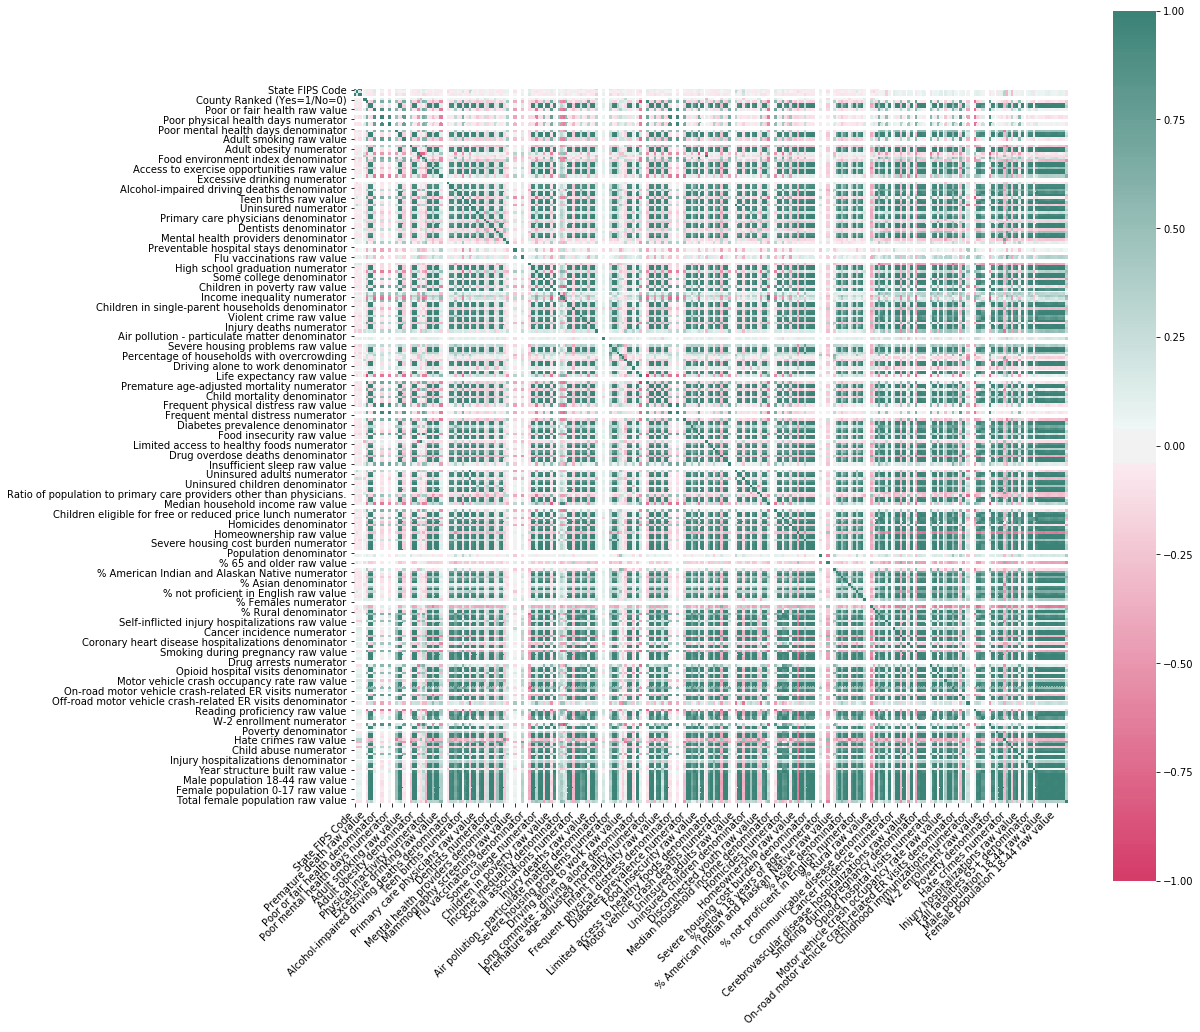

In [15]:
plt.figure(figsize=(16,16))
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0, 
    cmap=sns.diverging_palette(0,534,n=534),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

A list of the 60 variables that correlated most with the flu vaccine rate was created. Absolute values were taken for this as we are interested in large positive and negative correlations.

In [16]:
corr_matrix["Flu vaccinations raw value"].abs().sort_values(ascending=False)[:60]

Flu vaccinations raw value                                  1.000000
Hate crimes numerator                                       0.681341
Motor vehicle crash deaths raw value                        0.501493
Disconnected youth raw value                                0.483920
Firearm fatalities raw value                                0.458927
Homicides raw value                                         0.443868
Mammography screening raw value                             0.441988
Childhood immunizations raw value                           0.424479
Reading proficiency numerator                               0.421802
Child mortality raw value                                   0.420805
Children in poverty raw value                               0.401432
Teen births raw value                                       0.399579
Child abuse raw value                                       0.393808
Median household income raw value                           0.392461
Male population 65+ raw value     

A new daataframe containing only the relevant columns that are highly correlated with the target variable was then made.

In [17]:
df_relevant = df[['State Abbreviation','Name','5-digit FIPS Code','Flu vaccinations raw value',
                  'Motor vehicle crash deaths raw value','Disconnected youth raw value',
                  'Firearm fatalities raw value','Homicides raw value','Mammography screening raw value',
                  'Child mortality raw value','Children in poverty raw value','Teen births raw value',
                  'Injury deaths raw value','Median household income raw value']]

These columns had to then be converted into floats again. The 'State Abbreviation' and 'Name' columns were excluded from this as they were meant to be strings.

In [18]:
cols = df_relevant.columns
cols_included = list(filter(lambda col: col != 'State Abbreviation' and col != 'Name', cols))

for col in cols_included:
    df_relevant[col] = df_relevant[col].astype(float)

In [19]:
df_relevant.set_index('Name')

State Abbreviation  5-digit FIPS Code  \
Name                                                                      
Autauga County                                    AL             1001.0   
Baldwin County                                    AL             1003.0   
Barbour County                                    AL             1005.0   
Bibb County                                       AL             1007.0   
Blount County                                     AL             1009.0   
Bullock County                                    AL             1011.0   
Butler County                                     AL             1013.0   
Calhoun County                                    AL             1015.0   
Chambers County                                   AL             1017.0   
Cherokee County                                   AL             1019.0   
Chilton County                                    AL             1021.0   
Choctaw County                                    AL             1023.0   
Clarke County                                     AL             1025.0   
Clay County                                       AL             1027.0   
Cleburne County                                   AL             1029.0   
Coffee County                                     AL             1031.0   
Colbert County                                    AL             1033.0   
Conecuh County                                    AL             1035.0   
Coosa County                                      AL             1037.0   
Covington County                                  AL             1039.0   
Crenshaw County                                   AL             1041.0   
Cullman County                                    AL             1043.0   
Dale County                                       AL             1045.0   
Dallas County                                     AL             1047.0   
DeKalb County                                     AL             1049.0   
Elmore County                                     AL             1051.0   
Escambia County                                   AL             1053.0   
Etowah County                                     AL             1055.0   
Fayette County                                    AL             1057.0   
Franklin County                                   AL             1059.0   
Geneva County                                     AL             1061.0   
Greene County                                     AL             1063.0   
Hale County                                       AL             1065.0   
Henry County                                      AL             1067.0   
Houston County                                    AL             1069.0   
Jackson County                                    AL             1071.0   
Jefferson County                                  AL             1073.0   
Lamar County                                      AL             1075.0   
Lauderdale County                                 AL             1077.0   
Lawrence County                                   AL             1079.0   
Lee County                                        AL             1081.0   
Limestone County                                  AL             1083.0   
Lowndes County                                    AL             1085.0   
Macon County                                      AL             1087.0   
Madison County                                    AL             1089.0   
Marengo County                                    AL             1091.0   
Marion County                                     AL             1093.0   
Marshall County                                   AL             1095.0   
Mobile County                                     AL             1097.0   
Monroe County                                     AL             1099.0   
Montgomery County                                 AL             1101.0   
Morgan County                                     AL       

A correlation matrix was then plotted for this new dataframe.

In [20]:
corr_matrix2 = df_relevant.corr()

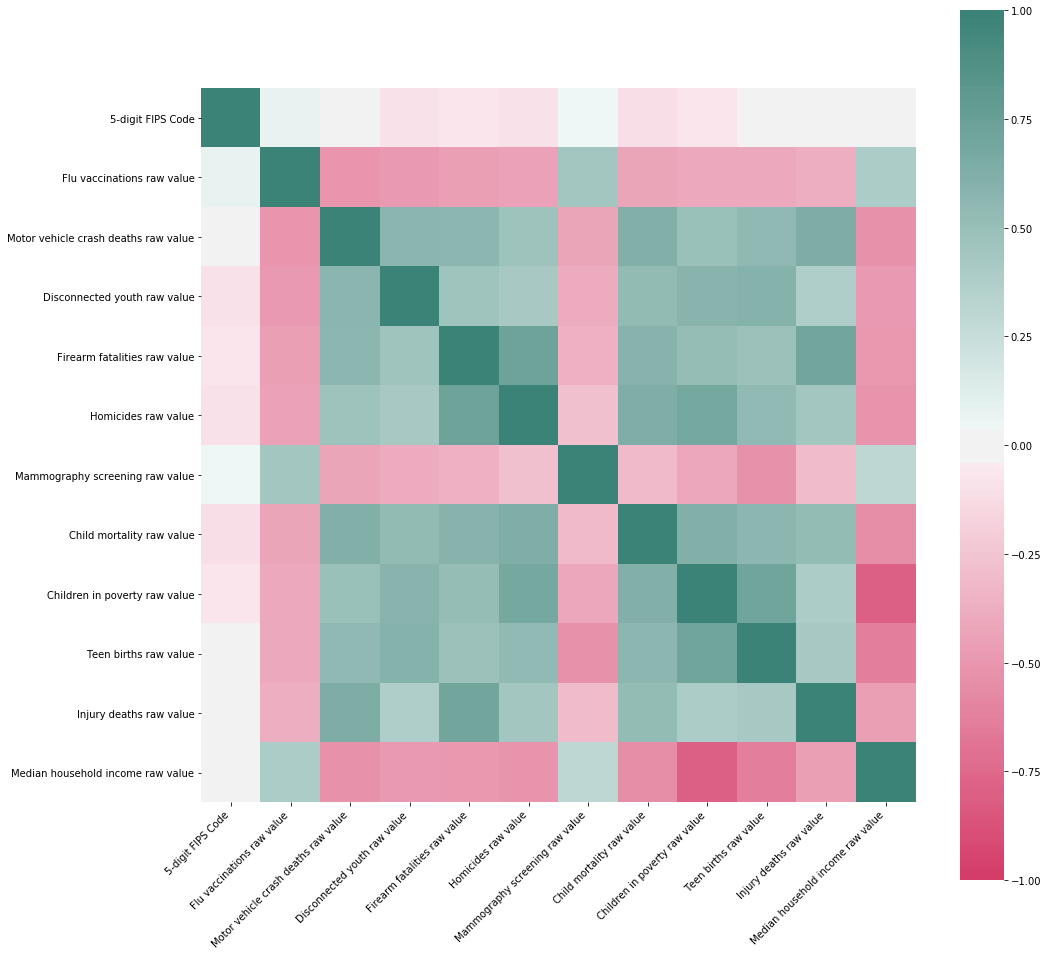

In [21]:
plt.figure(figsize=(16,16))
ax = sns.heatmap(
    corr_matrix2, 
    vmin=-1, vmax=1, center=0, 
    cmap=sns.diverging_palette(0,534,n=534),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

## 3.3 Merging Religion Dataframe.

In this section an new datasource was used to get the % of catholics that live in each county. This is because studies have shown that some followers of the religion are opposed to vaccinations.

In [22]:
df_religion = pd.read_excel ('US_religion_census_2010.xlsx')
df_religion = df_religion[['FIPS','CATHRATE']]
df_religion.set_index('FIPS', inplace=True)
df_religion.head()

CATHRATE
FIPS             
1001.0  32.358889
1003.0  76.858889
1005.0  20.940000
1007.0        NaN
1009.0  82.760000

In [23]:
len(df_religion)

3150

The religion dataframe was then merged with the original dataframe on the county FIPS codes.

In [24]:
df_relevant_religion = df_relevant.merge(df_religion, left_on='5-digit FIPS Code', right_on='FIPS')

In [25]:
len(df_relevant_religion)

3140

In [26]:
df_relevant_religion.head()

State Abbreviation            Name  5-digit FIPS Code  \
0                 AL  Autauga County             1001.0   
1                 AL  Baldwin County             1003.0   
2                 AL  Barbour County             1005.0   
3                 AL     Bibb County             1007.0   
4                 AL   Blount County             1009.0   

   Flu vaccinations raw value  Motor vehicle crash deaths raw value  \
0                        0.41                             20.377158   
1                        0.45                             15.092364   
2                        0.37                             20.966953   
3                        0.39                             25.272469   
4                        0.38                             25.711771   

   Disconnected youth raw value  Firearm fatalities raw value  \
0                      0.080117                          17.7   
1                      0.078257                          14.4   
2                      0.120448                          15.2   
3                           NaN                          21.3   
4                      0.151055                          19.7   

   Homicides raw value  Mammography screening raw value  \
0                  5.2                             0.44   
1                  2.9                             0.45   
2                  7.0                             0.46   
3                  8.2                             0.44   
4                  7.4                             0.36   

   Child mortality raw value  Children in poverty raw value  \
0                  53.279441                          0.193   
1                  47.000017                          0.147   
2                  77.080027                          0.503   
3                 111.749681                          0.273   
4                  76.032935                          0.185   

   Teen births raw value  Injury deaths raw value  \
0              26.524208                74.031808   
1              29.594009                69.374289   
2              45.092838                72.900134   
3              45.454545               100.077937   
4              35.600555               105.197227   

   Median household income raw value   CATHRATE  
0                            58343.0  32.358889  
1                            56607.0  76.858889  
2                            32490.0  20.940000  
3                            45795.0        NaN  
4                            48253.0  82.760000

The 'CATHRATE' column units was number of catholics per 1000 people in the county. This was converted to a percentage by dividing by 10 in the cell below.

In [27]:
df_relevant_religion['CATHRATE'] = df_relevant_religion['CATHRATE']/10

In the cells below we create another dataframe and group the counties by state in order to determine which states had the best and worst flu vaccination rates. The mean of each state variable is taken.

In [28]:
df_state_group = df_relevant_religion

In [29]:
cols = df_state_group.columns
cols_included = list(filter(lambda col: col != 'State Abbreviation' and col != 'Name', cols))

for col in cols_included:
    df_state_group[col] = df_state_group[col].astype(float)

In [30]:
df_state_group = df_state_group.groupby(['State Abbreviation']).mean()

From this we can then find the 10 states with the highest and lowest flu vaccine rates.

In [31]:
df_state_group.sort_values(by='Flu vaccinations raw value', ascending=True, inplace=True)
df_state_group2 = df_state_group['Flu vaccinations raw value']
df_lowest_state_group = df_state_group2.to_frame().head(10)
df_highest_state_group = df_state_group2.to_frame().tail(10)

In [32]:
df_state_group.head(5)

5-digit FIPS Code  Flu vaccinations raw value  \
State Abbreviation                                                  
AK                        2149.357143                    0.245000   
NV                       32045.529412                    0.309412   
MT                       30056.000000                    0.337679   
ID                       16044.000000                    0.339091   
NM                       35030.151515                    0.340606   

                    Motor vehicle crash deaths raw value  \
State Abbreviation                                         
AK                                             13.418321   
NV                                             19.285381   
MT                                             28.348791   
ID                                             19.840681   
NM                                             22.848674   

                    Disconnected youth raw value  \
State Abbreviation                                 
AK                                      0.151918   
NV                                      0.115560   
MT                                      0.117534   
ID                                      0.101911   
NM                                      0.110776   

                    Firearm fatalities raw value  Homicides raw value  \
State Abbreviation                                                      
AK                                     27.433333             8.000000   
NV                                     21.200000             4.800000   
MT                                     24.818182             5.800000   
ID                                     20.350000             2.950000   
NM                                     21.104000             9.026316   

                    Mammography screening raw value  \
State Abbreviation                                    
AK                                         0.318667   
NV                                         0.278824   
MT                                         0.385893   
ID                                         0.352273   
NM                                         0.311212   

                    Child mortality raw value  Children in poverty raw value  \
State Abbreviation                                                             
AK                                 110.530756                       0.181750   
NV                                  57.794395                       0.171647   
MT                                  80.836948                       0.191982   
ID                                  62.182571                       0.179068   
NM                                  59.375879                       0.306364   

                    Teen births raw value  Injury deaths raw value  \
State Abbreviation                                                   
AK                              35.629062               127.385709   
NV                              32.455997               104.956781   
MT                              30.983145               110.749826   
ID                              26.709452                88.215245   
NM                              43.035424               116.662787   

                    Median household income raw value   CATHRATE  
State Abbreviation                                                
AK                                       64118.714286   7.537338  
NV                                       59202.588235  13.635250  
MT                                       48109.232143  18.395196  
ID                                       50080.068182   9.268876  
NM                                       42273.696970  33.972764

## 3.4 Filling in NaN Values with State Median

The name column was saved as a list and dropped as filling in the state median is going to require completing mathematical operatioons on the columns, meaning all string columns must be excluded.

In [33]:
list_county_names = list(df_relevant_religion['Name'])
df_relevant_religion.drop(columns=['Name'], inplace=True)

The states are grouped and all of the existing NaN values are filled in with the median of that state.

In [34]:
df_relevant_religion.iloc[:,1:] = df_relevant_religion.groupby("State Abbreviation").transform(lambda x: x.fillna(x.median()))

The 'Name' column is then added back into the dataframe.

In [35]:
df_relevant_religion['Name'] = list_county_names

A final check for NaN values.

In [36]:
df_relevant_religion.isna().sum()

State Abbreviation                      0
5-digit FIPS Code                       0
Flu vaccinations raw value              0
Motor vehicle crash deaths raw value    0
Disconnected youth raw value            0
Firearm fatalities raw value            0
Homicides raw value                     0
Mammography screening raw value         0
Child mortality raw value               0
Children in poverty raw value           0
Teen births raw value                   0
Injury deaths raw value                 0
Median household income raw value       0
CATHRATE                                0
Name                                    0
dtype: int64

In [37]:
df_relevant_religion.set_index('Name').head()

State Abbreviation  5-digit FIPS Code  \
Name                                                   
Autauga County                 AL             1001.0   
Baldwin County                 AL             1003.0   
Barbour County                 AL             1005.0   
Bibb County                    AL             1007.0   
Blount County                  AL             1009.0   

                Flu vaccinations raw value  \
Name                                         
Autauga County                        0.41   
Baldwin County                        0.45   
Barbour County                        0.37   
Bibb County                           0.39   
Blount County                         0.38   

                Motor vehicle crash deaths raw value  \
Name                                                   
Autauga County                             20.377158   
Baldwin County                             15.092364   
Barbour County                             20.966953   
Bibb County                                25.272469   
Blount County                              25.711771   

                Disconnected youth raw value  Firearm fatalities raw value  \
Name                                                                         
Autauga County                      0.080117                          17.7   
Baldwin County                      0.078257                          14.4   
Barbour County                      0.120448                          15.2   
Bibb County                         0.097104                          21.3   
Blount County                       0.151055                          19.7   

                Homicides raw value  Mammography screening raw value  \
Name                                                                   
Autauga County                  5.2                             0.44   
Baldwin County                  2.9                             0.45   
Barbour County                  7.0                             0.46   
Bibb County                     8.2                             0.44   
Blount County                   7.4                             0.36   

                Child mortality raw value  Children in poverty raw value  \
Name                                                                       
Autauga County                  53.279441                          0.193   
Baldwin County                  47.000017                          0.147   
Barbour County                  77.080027                          0.503   
Bibb County                    111.749681                          0.273   
Blount County                   76.032935                          0.185   

                Teen births raw value  Injury deaths raw value  \
Name                                                             
Autauga County              26.524208                74.031808   
Baldwin County              29.594009                69.374289   
Barbour County              45.092838                72.900134   
Bibb County                 45.454545               100.077937   
Blount County               35.600555               105.197227   

                Median household income raw value  CATHRATE  
Name                                                         
Autauga County                            58343.0  3.235889  
Baldwin County                            56607.0  7.685889  
Barbour County                            32490.0  2.094000  
Bibb County                               45795.0  1.540000  
Blount County                             48253.0  8.276000

# 4. Modelling

This section outlines the model building part of the project. Several Methods of regression were completed and validated. The best performing model was then taken forward and tested on the test data.

## 4.1 Train-Test Splitting

The data needs to be split into the target variable (y) and the features (X). This data was then split again into a training set and testing set. The testing set was made to be 34% of the data we had as this would equate to aroung 1000 data points.

In [38]:
y = df_relevant_religion['Flu vaccinations raw value']
X = df_relevant_religion.drop(columns=['Flu vaccinations raw value','Name',
                                       'State Abbreviation','5-digit FIPS Code'], axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.66)

## 4.2. KFold

A KFold split was going to be used when testing the models. This 5 different training/test scenarios within the training data.

In [40]:
kf = KFold(n_splits=5)
kf

KFold(n_splits=5, random_state=None, shuffle=False)

## 4.3. Linear Regression (Baseline)

A baseline linear regression model was made. This. was done by completing a polynomial regression with a degree of 1. The cross_validate function was used to complete a 5-split KFold validation on the training data. The average of the training and test runs was then taken and printed.

In [41]:
scaler = preprocessing.StandardScaler()

poly = PolynomialFeatures(1)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
X_poly_train_s = scaler.fit_transform(X_poly_train)
X_poly_test_s = scaler.transform(X_poly_test)
lin_reg_poly = LinearRegression().fit(X_poly_train_s, y_train)

model_scores = cross_validate(lin_reg_poly, X_poly_train_s, y_train, scoring=('r2', 'neg_mean_squared_error'), cv=kf,
                      return_train_score=True)

print('degree: 1')
print('train_r2:',model_scores['train_r2'].mean())
print('test_r2:',model_scores['test_r2'].mean());

degree: 1
train_r2: 0.3177435316117502
test_r2: 0.3049790063547289


## 4.4. Polynomial Regression

A polynomial regression model was then created. It was found that a polynomial of degree 4 gave the best r^2 value, therefore this was run through a 5-split KFold validation. The mean of these results was then taken.

In [44]:
poly = PolynomialFeatures(4)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
X_poly_train_s = scaler.fit_transform(X_poly_train)
X_poly_test_s = scaler.transform(X_poly_test)
lin_reg_poly = LinearRegression().fit(X_poly_train_s, y_train)

model_score = cross_validate(lin_reg_poly, X_poly_train_s, y_train, scoring=('r2', 'neg_mean_squared_error'), cv=kf,
                      return_train_score=True)
if model_scores['test_r2'].mean() >= 0.1:
    print('degree: 4')
    print('train_r2:',model_scores['train_r2'].mean())
    print('test_r2:',model_scores['test_r2'].mean());

degree: 4
train_r2: 0.3177435316117502
test_r2: 0.3049790063547289


## 4.5. Lasso Regression

A lasso regression model was then created to reduce the coefficients of less important features to zero. This makes the model simpler and prevents overfitting. A for loop was created to iterate through increasing alpha values. Again the means from the KFold validation were printed. It was found that increasing the alpha didnt significantly change the difference in r^2 between the training and test data because the model was not overfitted in the first place.

In [ ]:
for alpha in np.linspace(0.0000001,1,1000):
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_poly_train_s, y_train)
    model_scores = cross_validate(lasso, X_poly_train_s, y_train, scoring=('r2', 'neg_mean_squared_error'), cv=kf,
                      return_train_score=True)
    if model_scores['test_r2'].mean() >= 0.3:
        print(f'alpha: {alpha}')
        print('train_r2:',model_scores['train_r2'].mean())
        print('test_r2:',model_scores['test_r2'].mean());

## 4.6. Ridge Regression

A ridge regression model was then created. This is similar to the Lasso regression in that it will reduce the weights of unimportant coefficients, however it will not reduce them all the way to zero. This model resulted in high r^2 values for the training data but similar r^2 for the test data. Incresing the alpha level reduced this overfitting, reaching a sweet spot at around alpha=2000.

In [50]:
for alpha in np.arange(1,5000,200):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_poly_train_s, y_train)
    model_scores = cross_validate(ridge, X_poly_train_s, y_train, scoring=('r2', 'neg_mean_squared_error'), cv=kf,
                      return_train_score=True)
    if model_scores['test_r2'].mean() >= 0.3:
        print(alpha)
        print('train_r2:',model_scores['train_r2'].mean())
        print('test_r2:',model_scores['test_r2'].mean());

201
train_r2: 0.44755351690351136
test_r2: 0.30937349290866456
401
train_r2: 0.4313744371300435
test_r2: 0.31274034681654966
601
train_r2: 0.42123244484443073
test_r2: 0.3154663152498835
801
train_r2: 0.41364214486886064
test_r2: 0.3175503372565235
1001
train_r2: 0.4075157008703747
test_r2: 0.31908421926090164
1201
train_r2: 0.4023552056435339
test_r2: 0.32017972835620556
1401
train_r2: 0.3978851576562993
test_r2: 0.32093239010973773
1601
train_r2: 0.3939349224155622
test_r2: 0.32141690802175954
1801
train_r2: 0.3903906636807166
test_r2: 0.32169033484902027
2001
train_r2: 0.3871723367161992
test_r2: 0.32179617215272127
2201
train_r2: 0.3842214049389355
test_r2: 0.3217678126463607
2401
train_r2: 0.3814937346698036
test_r2: 0.3216311422772339
2601
train_r2: 0.37895522624374295
test_r2: 0.32140644365439996
2801
train_r2: 0.376578995530751
test_r2: 0.3211097782439385
3001
train_r2: 0.3743434839376706
test_r2: 0.32075399340197464
3201
train_r2: 0.37223115003013063
test_r2: 0.320349461996952

## 4.7. Elastic Net Regression

Lastly, an elastic net regression model was created. This is a combination of Lasso and Ridge, applying both l1 and l2 penalisation to the coefficients. This yielded fairly similar results to the Lasso regression.

In [ ]:
for alpha in np.linspace(0.0000001,1,1000):
    elastic = ElasticNet(alpha=alpha).fit(X_poly_train_s,y_train)
    model_scores = cross_validate(elastic, X_poly_train_s, y_train, scoring=('r2', 'neg_mean_squared_error'), cv=kf,
                      return_train_score=True)
    if model_scores['test_r2'].mean() >= 0.3:
        print(alpha)
        print('train_r2:',model_scores['train_r2'].mean())
        print('test_r2:',model_scores['test_r2'].mean());

## 4.8. Model Selection

From comparing the r^2 values of the test and train data sets it was found that Ridge regression performed best. However, as previously mentioned, this meant the model had a huge number of features (>1000). Because of this, the Lasso regression model was chosen as this significantly reduced the number of features, making the model easier to maintain and more interpretable.

# 5. Testing

## 5.1. Training the Data on the Entire X_train_s Data

From our analysis, the best performing Lasso model had an alpha=0.001, however this still resulted in there being 46 features in the model. The alpha level was increased to 0.01 which reduced the r^2 to 0.30 but also reduced the number of feature to 9, making it much more interpretable. In the cell below the model is retrained against the entire training data set.

In [51]:
lasso = Lasso(alpha = 0.01)
lasso.fit(X_poly_train_s, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## 5.2. Testing on the Test Data

We then test the r^2 of the model against the X_test data set to assess its final performance.

In [53]:
test_r_squared = lasso.score(X_poly_test_s, y_test)

y_pred_test = lasso.predict(X_poly_test_s)
test_mse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Test r^2: {test_r_squared} \nTest MSE: {test_mse}')

Test r^2: 0.29878644066181137 
Test MSE: 0.08254147908461883


## 5.3. Plotting the Residuals

One of the assumptions of a Lasso regression model is that the distribution of residuals is normal. To check this, the distribution of residuals for the test and training data were plotted using the yellowbrick library.

In [54]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

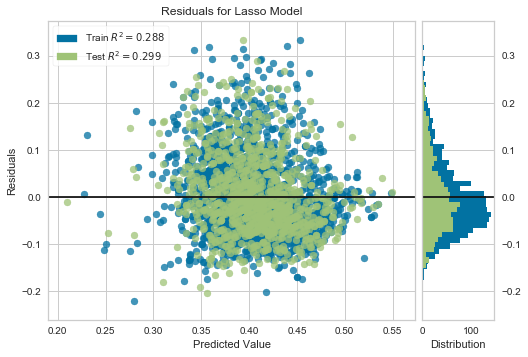

In [55]:
visualizer = ResidualsPlot(lasso)

visualizer.fit(X_poly_train_s, y_train)  # Fit the training data to the visualizer
visualizer.score(X_poly_test_s, y_test)  # Evaluate the model on the test data
visualizer.show()
plt.show()

From this plot we can see that there is a slight negative (right) skew. It is mostly normal, however this slight deviation from the assumption will be affecting the predictive power of the model and therefore it will be a key point of investigation in any future work.

## 5.4. Determining the Coefficients of the Model

This section aims to extract the relevant features from the model so that we can take action on aany insight we have. In the cells below we create a dataframe containing the coefficient weights and feature names. 

In [56]:
coefficient_weights = lasso.coef_
coefficient_df = pd.DataFrame()

In [57]:
columns = poly.get_feature_names(X_train.columns)
columns

['1',
 'Motor vehicle crash deaths raw value',
 'Disconnected youth raw value',
 'Firearm fatalities raw value',
 'Homicides raw value',
 'Mammography screening raw value',
 'Child mortality raw value',
 'Children in poverty raw value',
 'Teen births raw value',
 'Injury deaths raw value',
 'Median household income raw value',
 'CATHRATE',
 'Motor vehicle crash deaths raw value^2',
 'Motor vehicle crash deaths raw value Disconnected youth raw value',
 'Motor vehicle crash deaths raw value Firearm fatalities raw value',
 'Motor vehicle crash deaths raw value Homicides raw value',
 'Motor vehicle crash deaths raw value Mammography screening raw value',
 'Motor vehicle crash deaths raw value Child mortality raw value',
 'Motor vehicle crash deaths raw value Children in poverty raw value',
 'Motor vehicle crash deaths raw value Teen births raw value',
 'Motor vehicle crash deaths raw value Injury deaths raw value',
 'Motor vehicle crash deaths raw value Median household income raw value',


In [58]:
coefficient_df['Feature'] = columns
coefficient_df['weights'] = coefficient_weights

In [59]:
coefficient_df

Feature   weights
0                                                     1  0.000000
1                  Motor vehicle crash deaths raw value -0.010499
2                          Disconnected youth raw value -0.000000
3                          Firearm fatalities raw value -0.000000
4                                   Homicides raw value  0.000000
5                       Mammography screening raw value  0.007104
6                             Child mortality raw value -0.000000
7                         Children in poverty raw value -0.000000
8                                 Teen births raw value -0.000000
9                               Injury deaths raw value -0.005184
10                    Median household income raw value  0.000000
11                                             CATHRATE -0.000000
12               Motor vehicle crash deaths raw value^2 -0.000000
13    Motor vehicle crash deaths raw value Disconnec... -0.000000
14    Motor vehicle crash deaths raw value Firearm f... -0.000000
15    Motor vehicle crash deaths raw value Homicides... -0.000000
16    Motor vehicle crash deaths raw value Mammograp... -0.000000
17    Motor vehicle crash deaths raw value Child mor... -0.000000
18    Motor vehicle crash deaths raw value Children ... -0.000000
19    Motor vehicle crash deaths raw value Teen birt... -0.000000
20    Motor vehicle crash deaths raw value Injury de... -0.000000
21    Motor vehicle crash deaths raw value Median ho... -0.000000
22        Motor vehicle crash deaths raw value CATHRATE -0.002324
23                       Disconnected youth raw value^2 -0.000000
24    Disconnected youth raw value Firearm fatalitie... -0.000000
25     Disconnected youth raw value Homicides raw value -0.000000
26    Disconnected youth raw value Mammography scree... -0.000000
27    Disconnected youth raw value Child mortality r... -0.000000
28    Disconnected youth raw value Children in pover... -0.000000
29    Disconnected youth raw value Teen births raw v... -0.000000
30    Disconnected youth raw value Injury deaths raw... -0.000000
31    Disconnected youth raw value Median household ... -0.000000
32                Disconnected youth raw value CATHRATE -0.000000
33                       Firearm fatalities raw value^2 -0.000000
34     Firearm fatalities raw value Homicides raw value -0.000000
35    Firearm fatalities raw value Mammography scree... -0.000000
36    Firearm fatalities raw value Child mortality r... -0.000000
37    Firearm fatalities raw value Children in pover... -0.000000
38    Firearm fatalities raw value Teen births raw v... -0.000000
39    Firearm fatalities raw value Injury deaths raw... -0.000000
40    Firearm fatalities raw value Median household ... -0.000000
41                Firearm fatalities raw value CATHRATE -0.000000
42                                Homicides raw value^2 -0.000000
43    Homicides raw value Mammography screening raw ...  0.000000
44        Homicides raw value Child mortality raw value -0.000000
45    Homicides raw value Children in poverty raw value -0.000000
46            Homicides raw value Teen births raw value -0.000000
47          Homicides raw value Injury deaths raw value -0.000000
48    Homicides raw value Median household income ra...  0.000000
49                         Homicides raw value CATHRATE -0.000000
50                    Mammography screening raw value^2  0.000000
51    Mammography screening raw value Child mortalit...  0.000000
52    Mammography screening raw value Children in po... -0.000000
53    Mammography screening raw value Teen births ra... -0.000000
54    Mammography screening raw value Injury deaths ... -0.000000
55    Mammography screening raw value Median househo...  0.014350
56             Mammography screening raw value CATHRATE -0.000000
57                          Child mortality raw value^2 -0.000000
58    Child mortality raw value Children in poverty ... -0.000000
59      Child mortality raw value Teen births raw value -0.000000
60    Child mortality 

In [60]:
coefficient_df.sort_values(by='weights',inplace=True)
coefficient_df.reset_index(drop=True, inplace=True)
coefficient_df

Feature   weights
0                  Motor vehicle crash deaths raw value -0.010499
1                               Injury deaths raw value -0.005184
2                       Children in poverty raw value^4 -0.003384
3         Motor vehicle crash deaths raw value CATHRATE -0.002324
4     Disconnected youth raw value Firearm fatalitie... -0.000749
5     Disconnected youth raw value Firearm fatalitie... -0.000407
6     Firearm fatalities raw value Homicides raw val... -0.000000
7             Firearm fatalities raw value^2 CATHRATE^2 -0.000000
8     Firearm fatalities raw value^2 Median househol... -0.000000
9     Firearm fatalities raw value^2 Median househol... -0.000000
10    Firearm fatalities raw value^2 Injury deaths r... -0.000000
11    Firearm fatalities raw value^2 Injury deaths r... -0.000000
12    Firearm fatalities raw value^2 Teen births raw... -0.000000
13    Firearm fatalities raw value Homicides raw val... -0.000000
14    Firearm fatalities raw value^2 Teen births raw... -0.000000
15    Firearm fatalities raw value^2 Teen births raw... -0.000000
16    Firearm fatalities raw value^2 Teen births raw... -0.000000
17    Firearm fatalities raw value^2 Children in pov... -0.000000
18    Firearm fatalities raw value^2 Children in pov... -0.000000
19    Firearm fatalities raw value^2 Children in pov... -0.000000
20    Firearm fatalities raw value^2 Children in pov... -0.000000
21    Firearm fatalities raw value^2 Children in pov... -0.000000
22    Firearm fatalities raw value^2 Injury deaths r... -0.000000
23    Firearm fatalities raw value Homicides raw val... -0.000000
24                                                    1  0.000000
25    Firearm fatalities raw value^2 Child mortality... -0.000000
26    Firearm fatalities raw value Homicides raw val... -0.000000
27    Firearm fatalities raw value Homicides raw val... -0.000000
28    Firearm fatalities raw value Homicides raw val... -0.000000
29    Firearm fatalities raw value Homicides raw val... -0.000000
30    Firearm fatalities raw value Homicides raw val... -0.000000
31    Firearm fatalities raw value Homicides raw val... -0.000000
32    Firearm fatalities raw value Homicides raw val... -0.000000
33    Firearm fatalities raw value Homicides raw val... -0.000000
34    Firearm fatalities raw value Homicides raw val... -0.000000
35    Firearm fatalities raw value Homicides raw val...  0.000000
36    Firearm fatalities raw value Homicides raw val... -0.000000
37    Firearm fatalities raw value Homicides raw val... -0.000000
38    Firearm fatalities raw value Homicides raw val... -0.000000
39    Firearm fatalities raw value Homicides raw val...  0.000000
40    Firearm fatalities raw value Homicides raw val... -0.000000
41    Firearm fatalities raw value Homicides raw val... -0.000000
42    Firearm fatalities raw value Homicides raw val... -0.000000
43    Firearm fatalities raw value Homicides raw val... -0.000000
44    Firearm fatalities raw value Homicides raw val... -0.000000
45    Firearm fatalities raw value^2 Child mortality... -0.000000
46    Firearm fatalities raw value^2 Child mortality... -0.000000
47    Firearm fatalities raw value Homicides raw val... -0.000000
48    Firearm fatalities raw value^3 Child mortality... -0.000000
49    Firearm fatalities raw value^3 Mammography scr... -0.000000
50    Firearm fatalities raw value^3 Homicides raw v... -0.000000
51                       Firearm fatalities raw value^4 -0.000000
52              Disconnected youth raw value CATHRATE^3 -0.000000
53    Disconnected youth raw value Median household ... -0.000000
54    Disconnected youth raw value Median household ... -0.000000
55    Disconnected youth raw value Median household ... -0.000000
56    Disconnected youth raw value Injury deaths raw... -0.000000
57    Disconnected youth raw value Injury deaths raw... -0.000000
58    Disconnected youth raw value Injury deaths raw... -0.000000
59    Disconnected youth raw value Injury deaths raw... -0.000000
60    Disconnected you

In [61]:
# Indexes from 6 - 1361 (inclusive) are 0 values

The lasso regression reduces the weights (coefficients) of all unimportant features to 0, however they are still present in the model. In the cell below we remove these  features from the dataframe to leave just the features that are important.

In [62]:
coefficient_df_reduced = coefficient_df
coefficient_df_reduced = coefficient_df_reduced[coefficient_df['weights'] != 0]

In [63]:
coefficient_df_reduced

Feature   weights
0                  Motor vehicle crash deaths raw value -0.010499
1                               Injury deaths raw value -0.005184
2                       Children in poverty raw value^4 -0.003384
3         Motor vehicle crash deaths raw value CATHRATE -0.002324
4     Disconnected youth raw value Firearm fatalitie... -0.000749
5     Disconnected youth raw value Firearm fatalitie... -0.000407
1362                    Mammography screening raw value  0.007104
1363  Mammography screening raw value^2 Median house...  0.008758
1364  Mammography screening raw value Median househo...  0.014350

## 5.5. Inverse Transformation of Scaled Coefficients

Now that we had the features and their coefficients, we needed to inverse the StandardScaler transformation that we did on the training and test data so that we are left with meaningful coefficients.

We could not apply the inverse transformation on the coefficient_df_reduced as it needed to be done on the dataframe containing all features, including the ones that had a coefficient of 0. Therefore the original coefficient_df was used for this section.

In [64]:
coefficient_df_T = coefficient_df.T

In [65]:
len(coefficient_df_T.columns)

1365

In [66]:
coefficient_df_T

0                        1     \
Feature  Motor vehicle crash deaths raw value  Injury deaths raw value   
weights                            -0.0104992              -0.00518436   

                                    2     \
Feature  Children in poverty raw value^4   
weights                      -0.00338371   

                                                  3     \
Feature  Motor vehicle crash deaths raw value CATHRATE   
weights                                     -0.0023238   

                                                      4     \
Feature  Disconnected youth raw value Firearm fatalitie...   
weights                                        -0.00074868   

                                                      5     \
Feature  Disconnected youth raw value Firearm fatalitie...   
weights                                       -0.000406866   

                                                      6     \
Feature  Firearm fatalities raw value Homicides raw val...   
weights                                                 -0   

                                              7     \
Feature  Firearm fatalities raw value^2 CATHRATE^2   
weights                                         -0   

                                                      8     \
Feature  Firearm fatalities raw value^2 Median househol...   
weights                                                 -0   

                                                      9     \
Feature  Firearm fatalities raw value^2 Median househol...   
weights                                                 -0   

                                                      10    \
Feature  Firearm fatalities raw value^2 Injury deaths r...   
weights                                                 -0   

                                                      11    \
Feature  Firearm fatalities raw value^2 Injury deaths r...   
weights                                                 -0   

                                                      12    \
Feature  Firearm fatalities raw value^2 Teen births raw...   
weights                                                 -0   

                                                      13    \
Feature  Firearm fatalities raw value Homicides raw val...   
weights                                                 -0   

                                                      14    \
Feature  Firearm fatalities raw value^2 Teen births raw...   
weights                                                 -0   

                                                      15    \
Feature  Firearm fatalities raw value^2 Teen births raw...   
weights                                                 -0   

                                                      16    \
Feature  Firearm fatalities raw value^2 Teen births raw...   
weights                                                 -0   

                                                      17    \
Feature  Firearm fatalities raw value^2 Children in pov...   
weights                                                 -0   

                                                      18    \
Feature  Firearm fatalities raw value^2 Children in pov...   
weights                                                 -0   

                                                      19    \
Feature  Firearm fatalities raw value^2 Children in pov...   
weights                                                 -0   

                                                      20    \
Feature  Firearm fatalities raw value^2 Children in pov...   
weights                                                 -0   

                                                      21    \
Feature  Firearm fatalities raw value^2 Children in pov...   
weights                                                 -0   

                                                      22    \
Feature  Firearm fatalities raw value^2 Injury deaths r...   
weights                                     

In [67]:
coefficient_df_T = coefficient_df_T.iloc[-1:]
coefficient_df_T

0           1           2          3           4     \
weights -0.0104992 -0.00518436 -0.00338371 -0.0023238 -0.00074868   

                5    6    7    8    9    10   11   12   13   14   15   16    \
weights -0.000406866   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        17   18   19   20   21   22   23   24   25   26   27   28   29   30    \
weights   -0   -0   -0   -0   -0   -0   -0    0   -0   -0   -0   -0   -0   -0   

        31   32   33   34   35   36   37   38   39   40   41   42   43   44    \
weights   -0   -0   -0   -0    0   -0   -0   -0    0   -0   -0   -0   -0   -0   

        45   46   47   48   49   50   51   52   53   54   55   56   57   58    \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        59   60   61   62   63   64   65   66   67   68   69   70   71   72    \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        73   74   75   76   77   78   79   80   81   82   83   84   85   86    \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        87   88   89   90   91   92   93   94   95   96   97   98   99   100   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        101  102  103  104  105  106  107  108  109  110  111  112  113  114   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        115  116  117  118  119  120  121  122  123  124  125  126  127  128   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        129  130  131  132  133  134  135  136  137  138  139  140  141  142   \
weights   -0   -0   -0   -0   -0    0   -0   -0   -0   -0    0   -0   -0   -0   

        143  144  145  146  147  148  149  150  151  152  153  154  155  156   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        157  158  159  160  161  162  163  164  165  166  167  168  169  170   \
weights    0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        171  172  173  174  175  176  177  178  179  180  181  182  183  184   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        185  186  187  188  189  190  191  192  193  194  195  196  197  198   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        199  200  201  202  203  204  205  206  207  208  209  210  211  212   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        213  214  215  216  217  218  219  220  221  222  223  224  225  226   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        227  228  229  230  231  232  233  234  235  236  237  238  239  240   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        241  242  243  244  245  246  247  248  249  250  251  252  253  254   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        255  256  257  258  259  260  261  262  263  264  265  266  267  268   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        269  270  271  272  273  274  275  276  277  278  279  280  281  282   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        283  284  285  286  287  288  289  290  291  292  293  294  295  296   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0   

        297  298  299  300  301  302  303  304  305  306  307  308  309  310   \
weights   -0   -0   -0   -0    0   -0   -0    0   -0   -0   -0   -0   -0   -0   

        311  312  313  314  315  316  317  318  319  320  321  322  323  324   \
weights   -0   -0   -0   -0   -0   -0   -0   -0   -0   -0    0   -0   -0   -0   

        325  326  327  328  329  330  331  332  333  334  335  336  337  338   \
weights   -0   -0   -0   -0   -0   -0   -0   -0  

In the cell below we use the scaler.inverse_transform() function to reverse the transformation.

In [68]:
coefficient_df_inverse = scaler.inverse_transform(coefficient_df_T)

In [69]:
coefficient_df_inverse = pd.DataFrame(coefficient_df_inverse)

In [70]:
len(coefficient_df_inverse.columns)

1365

In [71]:
coefficient_df_inverse

0        1          2       3        4         5        6         7     \
0  0.989501  19.0094  0.0886635  14.864  5.24628  0.398691  61.0589  0.214594   

      8        9        10       11       12       13       14       15    \
0  32.0462  85.2918  51040.4  12.7108  442.576  1.81575  306.545  109.737   

      16      17       18       19       20      21       22          23    \
0  7.34507  1248.6  4.46439  679.683  1754.46  912990  220.629  0.00972271   

      24        25         26       27         28       29       30      31    \
0  1.41126  0.525199  0.0346116  5.77341  0.0208306  3.14202  7.86602  4323.8   

      32       33       34       35       36       37       38      39    \
0  1.05129  260.197  89.9391  5.77289  966.697  3.43647  517.369  1357.9   

     40      41       42       43       44      45       46       47    \
0  724070  165.21  40.6433  2.03285  357.219  1.3019  193.086  473.119   

     48       49        50       51         52       53       54       55    \
0  249148  56.5105  0.164613  23.9521  0.0828657  12.1948  33.4289  20652.6   

      56       57      58       59       60           61       62    \
0  5.21413  4145.41  14.004  2109.47  5399.87  2.99252e+06  701.684   

        63      64       65       66       67       68       69    \
0  0.0541849  7.8517  19.1558  9995.53  2.46077  1254.42  2879.73   

          70       71       72           73       74           75      76    \
0  1.51228e+06  370.254  7932.18  4.20464e+06  1045.21  2.78385e+09  693163   

      77     78       79       80       81       82       83       84    \
0  343.604  12512  45.0183  7545.26  2796.43  165.046  31523.7  112.245   

      85       86          87       88        89       90       91    \
0  17351.3  44223.2  2.0165e+07  4980.47  0.212217  30.6391  11.6517   

       92       93       94       95       96       97       98      99    \
0  0.685519  127.335  0.46113  70.6215  173.352  83518.3  20.4323  5676.4   

      100      101      102      103      104      105          106      107   \
0  1990.33  115.467  21071.5  76.1642  11593.6  29795.2  1.41666e+07  3171.18   

      108      109      110      111      112      113          114      115   \
0  902.978  41.2357  7998.78  29.4057  4403.65  10641.7  4.90861e+06  1069.87   

      116      117      118     119      120     121      122      123   \
0  2.94209  474.081  1.66738  250.48  663.518  357402  86.9357  92847.9   

      124      125     126          127      128      129      130      131   \
0  312.637  47956.3  119676  5.77128e+07  13502.5  1.21485  178.506  429.258   

     132      133      134      135          136      137     138   \
0  197005  47.2432  28869.5  65703.9  3.05644e+07  7511.15  175981   

          139      140          141          142     143         144   \
0  8.16436e+07  20157.2  4.62833e+10  1.12126e+07  6223.6  0.00143756   

       145        146         147       148        149       150       151   \
0  0.162744  0.0640709  0.00371757  0.679073  0.0025328  0.380301  0.890112   

      152       153      154      155       156     157       158      159   \
0  448.511  0.110278  26.0041  9.38157  0.536937  97.412  0.350844  53.2925   

      160      161      162      163       164    165       166      167   \
0  133.207  66104.6  14.9318  4.38617  0.200373  37.85  0.139328  20.7997   

      168      169      170       171      172        173      174      175   \
0  48.9524  23957.9  5.46738  0.013992  2.21419  0.0078775  1.17171  3.01311   

      176     177      178      179      180      181     182      183   \
0  1710.16  0.4191  425.133  1.44483  219.867  532.573  270832  62.5462   

         184       185      186     187       188      189      190     191   \
0  0.00571137  0.833522  1.92214  927.88  0.226143  133.224  292.443  142241   

      192      193     194      195          196      197      198      199   \
0  35.1383  765.219  371457  92.1877  2.24578e+08  54255.8  29.8

All of the feature columns that had a scaled coefficient of 0 were then removed in the cell below.

In [72]:
col_drop = np.arange(6,1362)
coefficient_df_inverse.drop(columns=col_drop,inplace=True)
coefficient_df_inverse

0        1          2       3        4         5            1362  \
0  0.989501  19.0094  0.0886635  14.864  5.24628  0.398691  1.09909e+12   

          1363    1364  
0  7.29013e+08  776701

In [73]:
coefficient_df_inverse = coefficient_df_inverse.T

In [74]:
coefficient_df_inverse.reset_index(drop=True, inplace=True)
coefficient_df_inverse.rename(columns={0:'Weight'}, inplace=True)

We then remap the feature names into the dataframe by using the coefficient_df_reduced feature column. 

In [75]:
columns = list(coefficient_df_reduced['Feature'])
columns

['Motor vehicle crash deaths raw value',
 'Injury deaths raw value',
 'Children in poverty raw value^4',
 'Motor vehicle crash deaths raw value CATHRATE',
 'Disconnected youth raw value Firearm fatalities raw value^2 Median household income raw value',
 'Disconnected youth raw value Firearm fatalities raw value Injury deaths raw value Median household income raw value',
 'Mammography screening raw value',
 'Mammography screening raw value^2 Median household income raw value',
 'Mammography screening raw value Median household income raw value']

In [76]:
coefficient_df_inverse['feature'] = columns

In [77]:
coefficient_df_inverse

Weight                                            feature
0     0.989501               Motor vehicle crash deaths raw value
1      19.0094                            Injury deaths raw value
2    0.0886635                    Children in poverty raw value^4
3       14.864      Motor vehicle crash deaths raw value CATHRATE
4      5.24628  Disconnected youth raw value Firearm fatalitie...
5     0.398691  Disconnected youth raw value Firearm fatalitie...
6  1.09909e+12                    Mammography screening raw value
7  7.29013e+08  Mammography screening raw value^2 Median house...
8       776701  Mammography screening raw value Median househo...

We are then left with a final dataframe containing the important features and their coefficients.